# Comparing models

In this notebook we create visualisations for comparing the models to include in our report write-up

## 1. Import Packages & Data

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 16.1 MB/s eta 0:00:00


In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.1.


In [3]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from scipy import stats

# modelling
from sklearn.metrics import confusion_matrix, f1_score
from scipy.stats import uniform, randint

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [6]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores

In [7]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


## Benchmarks

We add the benchmark model performances here

In [8]:
y_test = df_test.target_hr1.reset_index(drop=True)
y_pers = y_test.shift(1)

y_test = y_test.drop(0)
y_pers = y_pers.drop(0).astype(int)

In [9]:
# get transition indices for scoring
assert df_test.iloc[:, -1].name == 'transition'

# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = df_test.reset_index(drop=True).iloc[1:, -1]

# transition indices for all the sequences in the training set.
t_indices_test = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices_test - 1
t_indices_test = t_indices_test.append(before_t_indices)

In [10]:
y_test_trans = y_test[t_indices_test]
y_pers_trans = y_pers[t_indices_test]

In [11]:
per_f1 = np.round(f1_score(y_test, y_pers)*100, 2)
per_hss = heidke_skill_score(y_test, y_pers)
per_f1_trans = np.round(f1_score(y_test_trans, y_pers_trans)*100, 2)
per_hss_trans = np.round(heidke_skill_score(y_test_trans, y_pers_trans))

print("Persistence model results\nF1: {}\nTransition F1: {}\nHSS: {}\nTransition HSS: {}\n".format(per_f1, per_f1_trans, per_hss, per_hss_trans))

Persistence model results
F1: 64.86
Transition F1: 29.79
HSS: 0.6457
Transition HSS: -0.0



In [20]:
# from local run
harmonie_f1 = 22.18
harmonie_tf1 =  37.87
harmonie_hss = 0.2119
harmonie_thss = -0.0

In [21]:
harmonie_hss
harmonie_hss

0.2119

## Model Comparisions

Comparing models in terms of various metrics.

In [22]:

neptune_data = {'algorithm': ['RNN_LSTM', 'GRU', 'LSTM', 'ANN',
                      'RF', 'XGB', 'XGB (+19 vars)',
                      'XGB (RU)', 'XGBoost (SMOTE)',
                      'RF (AutoML)', 'Bagged_XGBoost', 'Persistence', 'Harmonie'],
        'F1': [33.51, 50.68, 39.96, 57.59, 60, 66.42, 66.67, 55.9, 64.86, 58.2, 67.16, per_f1, harmonie_f1],
        'Transition_F1': [25.5, 34.18, 29.08, 28.39, 22.7, 29.94, 31.65, 37.5, 29.79, 24.82, 30.49, per_f1_trans, harmonie_tf1],
        'HSS': [0.3314, 0.5027, 0.395, 0.5728, 0.5974, 0.6616, 0.6641, 0.5543, 0.6457, 0.5792, 0.6691, per_hss, harmonie_hss],
        'Transition_HSS': [0.0029, 0, -0.0019, -0.0673, -0.0481, -0.125, -0.0995, -0.2621, -0.2692, -0.0935,-0.0962, per_hss_trans, harmonie_thss]}

model_scores = pd.DataFrame(neptune_data).sort_values("F1", ascending=False).reset_index(drop=True)

In [23]:
# F1 and HSS encode the same information, so need to visualize both
model_scores.F1.corr(model_scores.HSS)

0.9999700298692662

In [24]:
model_scores

,algorithm,F1,Transition_F1,HSS,Transition_HSS
0,Bagged_XGBoost,67.16,30.49,0.6691,-0.0962
1,XGB (+19 vars),66.67,31.65,0.6641,-0.0995
2,XGB,66.42,29.94,0.6616,-0.1250
3,XGBoost (SMOTE),64.86,29.79,0.6457,-0.2692
4,Persistence,64.86,29.79,0.6457,-0.0000
5,RF,60.00,22.70,0.5974,-0.0481
6,RF (AutoML),58.20,24.82,0.5792,-0.0935
7,ANN,57.59,28.39,0.5728,-0.0673
8,XGB (RU),55.90,37.50,0.5543,-0.2621
9,GRU,50.68,34.18,0.5027,0.0000


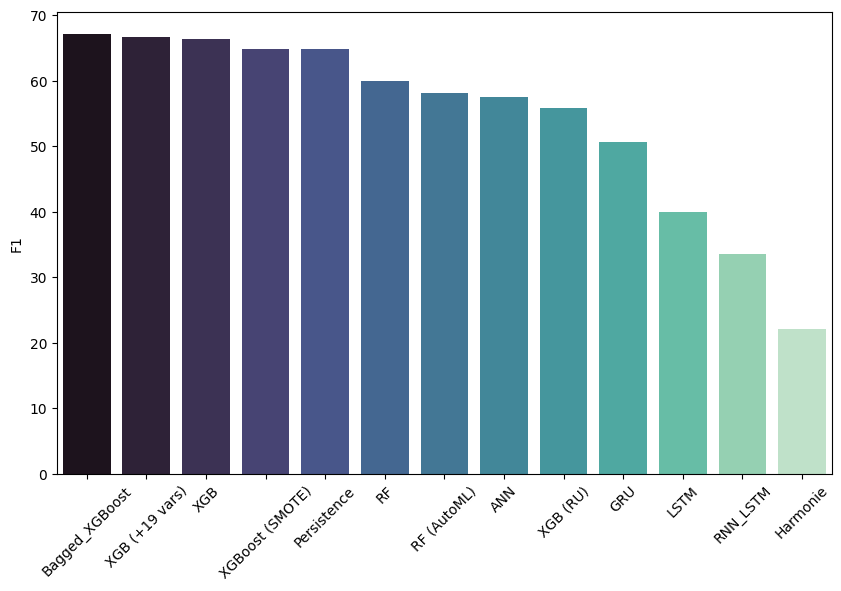

In [25]:
fig, ax = plt.subplots(figsize= (10, 6))

order = model_scores.sort_values('F1', ascending=False).algorithm
sns.barplot(x='algorithm', y='F1', data=model_scores, 
            order=order, dodge=False, palette='mako')

plt.xticks(rotation=45)
plt.xlabel(None)

plt.show()

In [26]:
# exclude persistence from plot
scores = model_scores.drop(4)

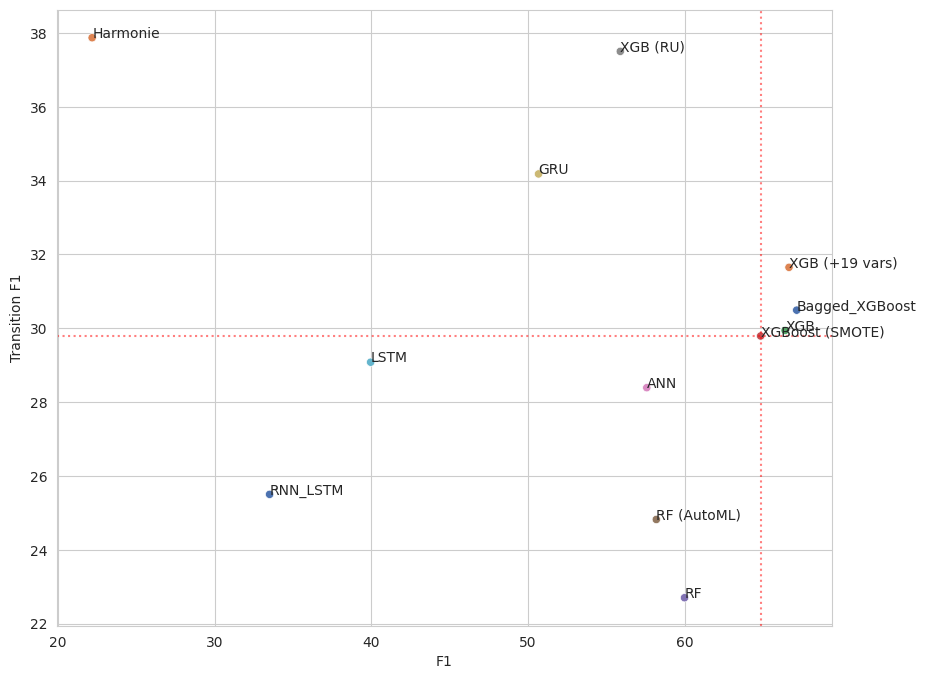

In [27]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize= (10, 8))

sns.scatterplot(x='F1', y='Transition_F1', data=scores, palette='deep', hue='algorithm')

# Add text labels to each data point
for i, txt in enumerate(np.arange(scores.shape[0])):
    plt.text(scores.F1.values[i], scores.Transition_F1.values[i], scores.algorithm.values[i])

plt.axvline(per_f1, linestyle=':', color='red', alpha=0.5)
plt.axhline(per_f1_trans, linestyle=':', color='red', alpha=0.5)

plt.ylabel("Transition F1")
plt.legend().set_visible(False)

plt.show()